<a href="https://colab.research.google.com/github/mlerma54/RSIGradCAM/blob/main/RSI_Grad_CAM_PyTorch_w_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSI-Grad-CAM (Rieman-Stieltjes Integrated Grad-CAM)**

# PyTorch version

# Model: VGG19

# Version of the code for public posting

In [1]:
# code version
ver='2023-12-27a'
print('code version:',ver)

code version: 2023-12-27a


In [2]:
import datetime
print('Last run:',datetime.datetime.now())

Last run: 2023-12-27 23:22:22.962790


In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# this is to time execution time
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.6 MB/s eta 0:00:00
time: 280 µs (started: 2023-12-27 23:22:49 +00:00)


Root dir

## <font color="red">Please give below paths as per the paths in your system<font>

In [5]:
root = root = '/content/gdrive/My Drive/RSI-Grad-CAM/'
images_dir = root + 'images/'

import os

for d in [root, images_dir]:
  print(d)
  assert(os.path.isdir(d))

/content/gdrive/My Drive/RSI-Grad-CAM/
/content/gdrive/My Drive/RSI-Grad-CAM/images/
time: 2.2 ms (started: 2023-12-27 23:22:49 +00:00)


# **Load packages**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

time: 5.85 s (started: 2023-12-27 23:22:49 +00:00)


In [7]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

time: 52.5 ms (started: 2023-12-27 23:22:55 +00:00)


---

In PyTorch it is hard to dissect pretrained network like the ones from the VGG family, so attribution methods like GradCAM, which need to extrat information from internal layers, need to be implemented with a previou knoledge of the structure of the network to which they are going to be applied. So, let's download a VGG network first and study its structure.

# **Pretrained VGG19 model**

In [8]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19', weights='VGG19_Weights.IMAGENET1K_V1')
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 167MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

time: 7.24 s (started: 2023-12-27 23:22:55 +00:00)


In [9]:
#IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = model.input.shape[1:]
IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3 = 3, 224, 224
INPUT_SHAPE = (IMAGE_SIZE_1, IMAGE_SIZE_2, IMAGE_SIZE_3)
IMAG_SIZE = (IMAGE_SIZE_2, IMAGE_SIZE_3)
print(INPUT_SHAPE, IMAG_SIZE)

(3, 224, 224) (224, 224)
time: 796 µs (started: 2023-12-27 23:23:03 +00:00)


In [10]:
summary(model.to(device), INPUT_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
model.features[35]

ReLU(inplace=True)

time: 2.83 ms (started: 2023-12-27 23:23:04 +00:00)


In [12]:
print([n for n, _ in model.named_children()])

['features', 'avgpool', 'classifier']
time: 529 µs (started: 2023-12-27 23:23:04 +00:00)


In [13]:
getattr(model,'features')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

time: 2.86 ms (started: 2023-12-27 23:23:04 +00:00)


In [14]:
print([n for n, _ in model.features.named_children()])

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36']
time: 1.14 ms (started: 2023-12-27 23:23:04 +00:00)


In [15]:
getattr(model,'features')[35]

ReLU(inplace=True)

time: 2.81 ms (started: 2023-12-27 23:23:04 +00:00)


---

# **Display heatmaps**

In [16]:
#def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_VIRIDIS):
#def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_HOT):

def overlay_heatmap(heatmap,image,alpha=0.5,colormap=cv2.COLORMAP_JET): # improved colormap 4/25/2022
  '''
  apply the supplied color map to the heatmap and then
  overlay the heatmap on the input image
  '''

  heatmap = cv2.applyColorMap(heatmap, colormap) # produce colormap
  heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) # convert to RGB
  output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)

  # return a 2-tuple of the color mapped heatmap and the output, overlaid image
  return (heatmap, output)

time: 682 µs (started: 2023-12-27 23:23:04 +00:00)


Plotting function

In [17]:
# this function determines if a tensor can be interpreted as a prob. dist. (e.g. output of a softmax)
def is_prob_dist(x):
  return (torch.all(x >= 0) and torch.all(x <= 1) and torch.abs(torch.sum(x.flatten().squeeze()) - 1.0) < 1e-8)

time: 530 µs (started: 2023-12-27 23:23:04 +00:00)


In [18]:
# Read the categories
with open(root + "imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

time: 562 ms (started: 2023-12-27 23:23:04 +00:00)


In [19]:
# preprocess images for us with VGG network

preprocess = transforms.Compose([
      #transforms.Resize(256),
      #transforms.CenterCrop(224),
      transforms.Resize(IMAG_SIZE, antialias=None), # <-
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # <- needed for using VGG trained with ImageNet
])

time: 740 µs (started: 2023-12-27 23:23:05 +00:00)


In [20]:
def display_heatmaps(imag_filename, attr_method_instance, top_pred=0):
  '''
  INPUT parameters:
  - image_filename: path to image file. e.g. image_filename = images_dir + 'beagle.jpg'
  - attr_method_instance: attribution method instance, e.g.: attr_method_instance = gcmodel
  - add_softmax: set True if the model lacks a final softmax (otherwise 'probabilities' will actually be logits)
  - top_pred = which class we what to locate starting a the top predicted,
    i.e., 0 = class with the top (highest) score, 1 = second top, etc.
  '''

  input_image = Image.open(imag_filename)
  input_image

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  input_batch = input_batch.to(device)
  model.to(device)

  # this should produce the model ouput
  out = attr_method_instance(input_batch)

  # top model predictions
  if is_prob_dist(out[0]):
    probabilities = out[0]
  else:
    probabilities = F.softmax(out[0], dim=0)

  # Show top categories per image
  top5_prob, top5_catid = torch.topk(probabilities, 5)
  for i in range(top5_prob.size(0)):
    print(i, top5_catid[i].item(), categories[top5_catid[i]], top5_prob[i].item())

  print()

  # predicted class
  classIdxPred = out.argmax().item()
  classIdxSel = out[0].argsort(descending=True)[top_pred].item()
  print('predicted, class:', classIdxPred)
  print('selected, class: ', classIdxSel)
  print()

  heatmap = attr_method_instance.compute_heatmap(input_batch, classIdxSel)
  heatmap = cv2.resize(heatmap.detach().cpu().numpy(), (input_image.size[0], input_image.size[1]))

  input_image_np = np.asarray(input_image)
  print(input_image_np.shape)
  print()

  heatmap, output = overlay_heatmap(heatmap,input_image_np)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,10))
  ax1.imshow(input_image)
  ax1.axis('off')
  ax2.imshow(heatmap)
  ax2.axis('off')
  ax3.imshow(output)
  ax3.axis('off')

  plt.show()

  print()

time: 1.74 ms (started: 2023-12-27 23:23:05 +00:00)


# **RSI-Grad-CAM**

In [21]:
# RSI Grad-CAM in PyTorch

class RSI_GradCamModel(nn.Module):

  def __init__(self, model, submodule_name, layer_no, baseline=None, m_steps=50, add_softmax=False):
    '''
    INPUT parameters
    - model: CNN to which we wish to apply this attribution method
    # the following may change depending on the network structure, these should work for sequential models like the VGG family
    - submodule_name: e.g. 'features' in model.features[35]
    - layer_no: e.g.: 35 in model.features[35]
    #------------------------------------------------------------
    - baseline: baseline input
    - use_positive_grads: set True to use only positive gradients in computing the weights (guide gradients?) to combine the feature maps
    - add_softmax: set True if the model lacks a final softmax and you want to add it for computing heatmaps
    '''

    super().__init__()
    self.gradients = None
    self.tensorhook = []
    self.layerhook = []
    self.selected_out = None

    self.model = model
    self.submodule_name = submodule_name
    self.layer_no = layer_no
    self.baseline=baseline
    self.m_steps = m_steps # number of interpolation steps
    self.add_softmax = add_softmax

    #self.layerhook.append(self.model.features[35].register_forward_hook(self.forward_hook())) # <- REGISTER THE LAYER WHERE HEATMAPS ARE GOING TO BE GENERATED

    # REGISTER THE LAYER WHERE HEATMAPS ARE GOING TO BE GENERATED
    # the submodule is accessed by name and the layer by number
    self.layerhook.append(getattr(self.model,self.submodule_name)[self.layer_no].register_forward_hook(self.forward_hook()))

    for p in self.model.parameters():
        p.requires_grad = True

  def activations_hook(self,grad):
    self.gradients = grad

  def get_act_grads(self):
    return self.gradients

  def forward_hook(self):
    def hook(module, inp, out):
      self.selected_out = out
      self.tensorhook.append(out.register_hook(self.activations_hook))
    return hook

  def interpolate_images(self, baseline, image, alphas):
    '''
    Returns an array of images interpolated between baseline and final image
    '''

    alphas_x = alphas[:, None, None, None]
    baseline_x = torch.unsqueeze(baseline, axis=0)
    input_x = torch.unsqueeze(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

  def stieltjes_integral_approximation(self, gradients, convOutputs):
    '''
    Riemann-Stieltjes Integral approximation,
    arguments are integrand and integrator respectively
    '''

    # riemann_trapezoidal (average height of trapezoid)
    grads = (gradients[:-1] + gradients[1:]) / 2.0
    # integrator increments (lenght of trapezoid base)
    incr_convOutputs = convOutputs[1:] - convOutputs[:-1]
    # terms in the Riemann-Stieltjes Integral approximation
    summands = grads * incr_convOutputs
    # add them up
    integrated_gradients = torch.sum(summands, axis=0)
    return integrated_gradients

  def compute_heatmap(self, image, classIdx, eps=1e-8):
    # image should be a 3D or 4D torch tensor with batch and channels first

    im_shape = image.shape
    if len(im_shape) == 4 and im_shape[0] == 1:
      image_sqz = image[0] # remove single batch dimension
    elif len(im_shape) == 3:
      image_sqz = image
      image = torch.unsqueeze(image_sqz, 0)
    else:
      raise ValueError("Input image shape {} is invalid.".format(im_shape))

    if image_sqz.shape != self.baseline.shape:
      raise ValueError("Input and baseline images have different shapes: {} {}".format(image_sqz.shape,self.baseline.shape))

    # create the sequence of interpolated images as a single batch
    alphas = torch.linspace(start=0.0, end=1.0, steps=self.m_steps+1).to(device)
    image_batch = self.interpolate_images(self.baseline, image_sqz, alphas)

    # find gradients - loss has to be scalar, this cannot be done in a batch
    grads_list = []
    acts_list = []
    for i in range(self.m_steps + 1):
      out = self.model(torch.unsqueeze(image_batch[i],0))
      if self.add_softmax:
        out = F.softmax(out,dim=-1)
      acts = self.selected_out
      loss = out[:, classIdx] # loss has to be scalar, this cannot be done in a batch
      loss.backward()
      acts_list.append(acts)
      grads_list.append(F.relu(self.gradients))

    acts_batch = torch.stack(acts_list)
    grads_batch = torch.stack(grads_list)

    integrated_gradients = self.stieltjes_integral_approximation(grads_batch,acts_batch)

    pooled_grads = torch.mean(integrated_gradients, dim=[0,2,3])

    for i in range(acts.shape[1]):
        acts[:,i,:,:] *= pooled_grads[i]


    heatmap_j = torch.mean(acts, dim = 1).squeeze()
    heatmap_j = F.relu(heatmap_j) # final ReLU

    (w, h) = (image.shape[2], image.shape[3])
    resized_heatmap = torchvision.transforms.Resize((w, h), antialias=None)(torch.unsqueeze(heatmap_j,0))[0]
    numer = resized_heatmap - torch.min(resized_heatmap)
    denom = torch.max(resized_heatmap) - torch.min(resized_heatmap) + eps # eps = small epsilon to be added to denominator to avoid division by zero
    heatmap = numer / denom
    heatmap = (heatmap * 255).type(torch.uint8)

    return heatmap # don't forget to move it to the cpu and convert to numpy array after returning: heatmap = heatmap.detach().cpu().numpy()

  def forward(self,x):
    out = self.model(x)
    if self.add_softmax:
      out = F.softmax(out,dim=-1)
    return out

time: 2.19 ms (started: 2023-12-27 23:23:05 +00:00)


In [22]:
baseline = torch.zeros(INPUT_SHAPE)
baseline_img = transforms.ToPILImage()(baseline)
baseline = preprocess(baseline_img).to(device)

time: 25.7 ms (started: 2023-12-27 23:23:05 +00:00)


In [23]:
rsi_gcmodel = RSI_GradCamModel(model,'features',36,baseline=baseline, add_softmax=True).to(device)

time: 2.68 ms (started: 2023-12-27 23:23:05 +00:00)


0 714 pick 0.9999991655349731
1 722 ping-pong ball 3.647180051302712e-07
2 767 rubber eraser 2.2672695365599793e-07
3 746 puck 2.1007846839893318e-07
4 433 bathing cap 3.2507113445490177e-08

predicted, class: 714
selected, class:  714

(432, 432, 3)



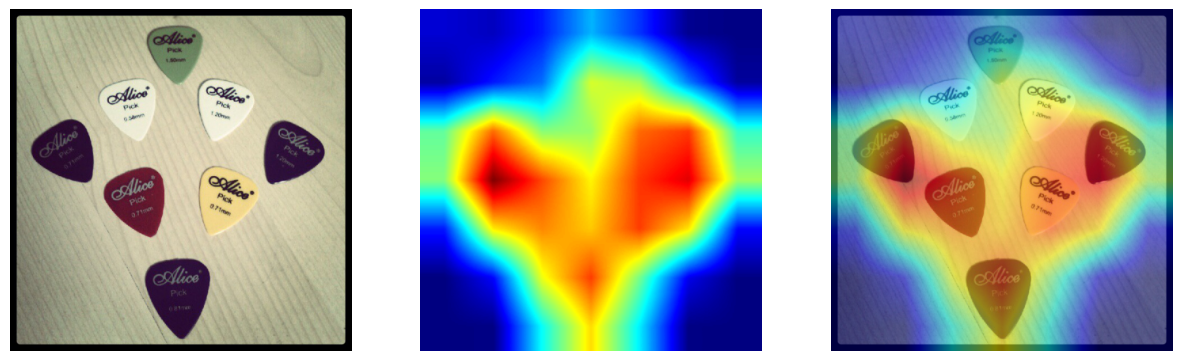


time: 3.07 s (started: 2023-12-27 23:23:05 +00:00)


In [24]:
image_filename = images_dir + 'pick.jpg'
display_heatmaps(image_filename, rsi_gcmodel)

---

In [25]:
rsi_gcmodel27 = RSI_GradCamModel(model,'features',27,baseline=baseline, add_softmax=True).to(device)

time: 2.16 ms (started: 2023-12-27 23:23:08 +00:00)


0 714 pick 0.9999991655349731
1 722 ping-pong ball 3.647180051302712e-07
2 767 rubber eraser 2.2672695365599793e-07
3 746 puck 2.1007846839893318e-07
4 433 bathing cap 3.2507113445490177e-08

predicted, class: 714
selected, class:  714

(432, 432, 3)



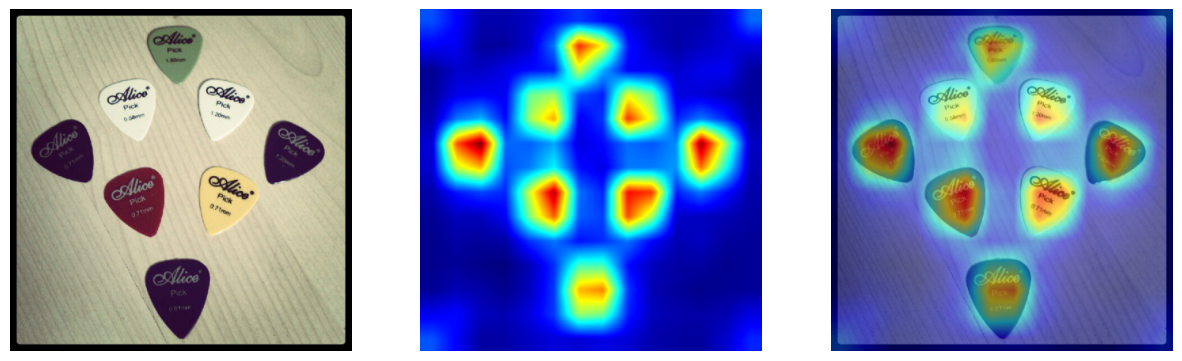


time: 1.02 s (started: 2023-12-27 23:23:08 +00:00)


In [26]:
image_filename = images_dir + 'pick.jpg'
display_heatmaps(image_filename, rsi_gcmodel27)